## Imports
All of the IceVision components can be easily imported with a single line.


In [1]:
from icevision import models, tfms, Dataset
import torch
from PIL import Image, ImageDraw, ImageFont

### Functions

In [2]:
def model_selection(model_number):
    image_size = 384
    model_type = None
    backbone = None
    extra_args = {}
    if model_number == 0:
        model_type = models.mmdet.retinanet
        backbone = model_type.backbones.resnet50_fpn_1x

    elif model_number == 1:
        # The Retinanet model is also implemented in the torchvision library
        model_type = models.torchvision.retinanet
        backbone = model_type.backbones.resnet50_fpn

    elif model_number == 2:
        model_type = models.ross.efficientdet
        backbone = model_type.backbones.tf_lite0
        # The efficientdet model requires an img_size parameter
        extra_args['img_size'] = image_size

    elif model_number == 3:
        model_type = models.ultralytics.yolov5
        backbone = model_type.backbones.small
        # The yolov5 model requires an img_size parameter
        extra_args['img_size'] = image_size

    # Instantiate the model
    # !TODO need to figure out how to get the len of the classmap from the data dict
    return model_type, model_type.model(backbone=backbone(pretrained=True), num_classes=4, **extra_args)


def load_model(model_path, model_number, device):
    model_type, model = model_selection(model_number)
    model.load_state_dict(torch.load(model_path, map_location=device))
    return model_type, model

def convert_img_to_ds(img):
    infer_tfms = tfms.A.Adapter([*tfms.A.resize_and_pad(size=384), tfms.A.Normalize()])
    return Dataset.from_images([img], infer_tfms)

def predict(model_type, model, img):
    infer_ds = convert_img_to_ds(img)
    preds = model_type.predict(model, infer_ds, keep_images=True)
    for x in preds[0].detection.components:
        if 'ScoresRecordComponent' in str(x):
            scores = x.scores
        if 'InstancesLabelsRecordComponent' in str(x):
            labels = x.label_ids
        if 'BBoxesRecordComponen' in str(x):
            bboxes = []
            for bbox in x.bboxes:
                min = [bbox.xmin,bbox.ymin]
                max = [bbox.xmax,bbox.ymax]
                bboxes.append([min,max])
                
    return labels, scores, bboxes



def overlap_percent(bbox1, bbox2):
    # calculates the overlap ratio given 1 rectangle with corners l1 and r2 and 
    # the other with corners l2 and r2
    l1 = bbox1[0]
    r1 = bbox1[1]
    l2 = bbox2[0]
    r2 = bbox2[1]
    x = 0
    y = 1

    x_dist = (min(r1[x], r2[x]) -
              max(l1[x], l2[x]))
    y_dist = (min(r1[y], r2[y]) -
              max(l1[y], l2[y]))
    areaI = 0
    if x_dist > 0 and y_dist > 0:
        areaI = x_dist * y_dist
        
    area1 = abs( (l1[0]-r1[0])*(l1[1]-r1[1]) )
    overlap = areaI / area1
 
    return overlap


def select_bbox(labels, scores, bboxes):
    person_label = 3 # label of person
    logo_labels = [1,2] # list of logo lables
    overlap_threshold = 0.5 # ratio of overlap for obfiscating 
    bboxes_out = []
    for i in range(len(labels)):
        for j in range(len(labels)):
            if labels[i] == person_label:
                if labels[j] in logo_labels:
                    bbox1 = bboxes[j] # logo
                    bbox2 = bboxes[i] # person
                    overlap = overlap_percent(bbox1, bbox2)
                    if overlap >= overlap_threshold:
                        bboxes_out.append(bbox1)                       
    return bboxes_out

def show_predict(img, labels, scores, bboxes):
    img2 = img.copy()
    draw2 = ImageDraw.Draw(img2)
    width, height = img2.size
    w_ratio = width / 380
    h_ratio = height / 380
    for bbox, label in zip(bboxes,labels):
        bbox1 = [ tuple([bbox[0][0]*w_ratio,bbox[0][1]*h_ratio]), tuple([bbox[1][0]*w_ratio,bbox[1][1]*h_ratio]) ]
        if label == 3:
            color ="red"
        else:
            color = "yellow"
        draw2.rectangle(bbox1, outline =color)

    img2.show()


def obfuscate(img,bboxes_remove):
    # removes all the rectangles in bbox_out list
    img2 = img.copy()
    draw2 = ImageDraw.Draw(img2)
    width, height = img2.size
    w_ratio = width / 380
    h_ratio = height / 380
    for bbox in bboxes_remove:
        bbox1 = [ tuple([bbox[0][0]*w_ratio,bbox[0][1]*h_ratio]), tuple([bbox[1][0]*w_ratio,bbox[1][1]*h_ratio]) ]
        color = "yellow"
        draw2.rectangle(bbox1, outline =color, fill=color)

    return img2

## Run

Infer time in seconds: 0.03988504409790039


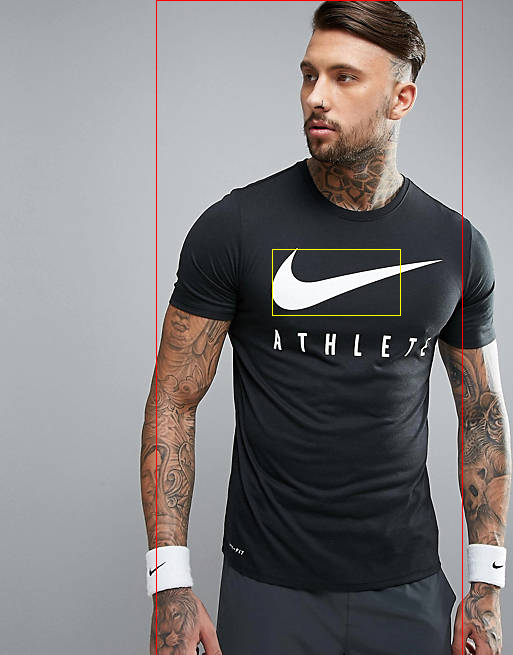

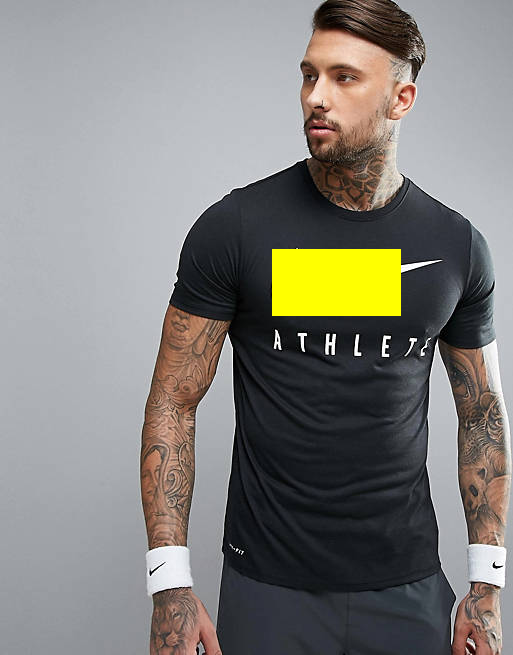

In [10]:

img = Image.open('./1.jpg')  # also try './2.jpg' ... './5.jpg'
    
#################################    
#### prepare before loop (creates model and loads weights)
# model_path = 'nikemodel_model_3_new_20.mm'
# model_number = 3

model_path = 'model_3_unfreeze_20.mm'
model_number = 3

device = torch.device('cpu') # or device = torch.device('cuda')
model_type, model = load_model(model_path, model_number, device)


########## !!!!!!!! disable for final use  ###########
import time # timing # !!!!!!!! disable for final use
start = time.time() # timing # !!!!!!!! disable for final use

#################################
### infer within the loop (gets a pillow format image and rturns obfuscated image)
labels, scores, bboxes = predict(model_type, model, img)
bboxes_remove = select_bbox(labels, scores, bboxes)
img_out = obfuscate(img, bboxes_remove)

########## !!!!!!!! disable for final use  ###########
end = time.time() # timing # 
print("Infer time in seconds:", end - start) # timing # 
show_predict(img, labels, scores, bboxes) # 
img_out

